In [15]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from math import exp
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
env = gym.make('MountainCar-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
for i_episode in range(10):
    observation = env.reset()
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

In [4]:
print(env.action_space)

Discrete(3)


In [5]:
env.action_space

Discrete(3)

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(256, 3)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
        

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
#     screen = np.dot(screen, [0.299, 0.587, 0.114])
#     screen = np.reshape(screen, (1, screen.shape[0], screen.shape[1]))
    screen = screen.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)
    return screen

In [9]:
#pixel vals of screen (3,800,1200)
print(get_screen().shape)

torch.Size([1, 3, 40, 60])


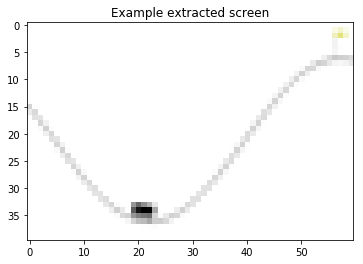

In [10]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [11]:
#position of agent
print(env.state[0])

-0.5689313929281197


In [12]:
print("Min positiion: " + str(env.min_position))
print("Goal positiion: " + str(env.goal_position))
print("Max positiion: " + str(env.max_position))

Min positiion: -1.2
Goal positiion: 0.5
Max positiion: 0.6


Goal: Define a reward as minimizing goal position - env.state[0] (cart position)

In [13]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [31]:
def plot_rewards():
    plt.figure(3)
    plt.clf()

    plt.title('Rewards')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.plot(rewards)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

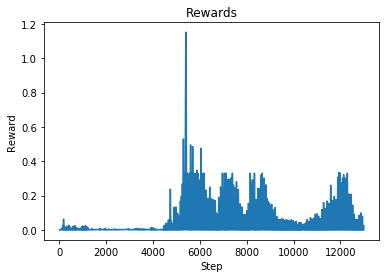

KeyboardInterrupt: 

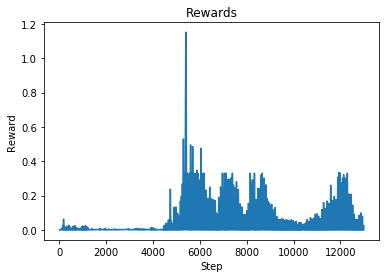

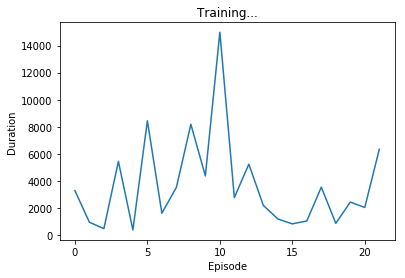

In [34]:
num_episodes = 50
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 2

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    init_pos = env.state[0]
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    rewards = []
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        
        last_pos = env.state[0]
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        curr_pos = env.state[0]

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        
        #rewards
#         if env.state[0] == env.min_position:
#             reward += 20

        #linear reward
#         if env.state[0] > init_pos + .3:
#             reward += (init_pos+.3)*10
#         if env.state[0] > init_pos - .3:
#             reward += abs(init_pos-.3)*10
        
        #exp reward
        if env.state[0] - init_pos <= 0:
            reward += 1.0 + abs(env.state[0] - init_pos)**3
        else:
            reward += 1.0 + 2*abs(env.state[0] - init_pos)**3
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            reward += 100000
            if t > 1000:
                reward *= (1000.0/t)
                
        if t % 100 == 0 and t > 0:
#             plt.plot(np.arange(0,t),rewards)
#             plt.show()
            plot_rewards()
#             time.sleep(1)
        
        rewards.append(reward)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()


In [98]:
#need to use more features in DQN model

In [ ]:
policy = policy_net.state_dict()
target = target_net.state_dict()

checkpoint = {
    'policy': policy,
    'target': target
    'optim': self.optim,
}
name = 'car-v1.h5'
step = num_episodes
checkpoint_path = '%s_step_%d.pt' % (name, step)
torch.save(checkpoint, checkpoint_path)